# Project Capstone                ----- Alumna:

## Model and train

La **les dades del bicing** ja han estat descarregades de la web de l'ajuntament i preprocessades. 
Ara tenim el dataframe preparat per dividir -estratificant prèviament o no, entre train i test(validation)

Haurem d'anar afegint les variables addicionals que volguem i estandaritzar i/o d'altres transformacions..


In [1]:
import numpy as np
import os 

In [2]:
import pandas as pd

from sklearn import set_config
# to obtain a pandas df to the output of 'fit_transform' instead a numpy arrary
#set_config(transform_output="pandas")

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import pel training

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error,r2_score

from sklearn.ensemble import RandomForestRegressor
#from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [5]:
from sklearn.impute import SimpleImputer #per assignar la mitjana ó ... on hi ha NANS

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [148]:
from sklearn.preprocessing import LabelEncoder

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [7]:
from datetime import datetime

In [8]:
seed=42
np.random.seed(seed)

In [9]:
# import custom library

#from DataClean import clean_data_pipeline
#from DataReestructure import transform_data_pipeline
from DataLoad import restore_stations_loc_info, load_holidaysBCN
from MeteoBCN import load_meteocat_data

In [10]:
from MeteoBCN import AssignWeatherVariables

### Anem a entrenar ###

In [102]:
#recuperem el fitxer de training 
dftotrain=pd.read_csv(f'data_bicing/Bicing_ToTrain.csv')

In [103]:
dftotrain.head()

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,0.244565,0.054348
1,1,2019,3,29,3,46.0,16.0,0.000000,0.009058,0.003623,0.018116,0.000000
2,1,2019,3,29,8,46.0,16.0,0.432971,0.009058,0.007246,0.036232,0.324275
3,1,2019,3,29,13,46.0,16.0,0.110507,0.525362,0.268116,0.253623,0.197464
4,1,2019,3,29,18,46.0,16.0,0.021739,0.019928,0.054348,0.013587,0.005435


In [104]:
dftotrain.isnull().values.any()

False

In [105]:
#dftotrain.shape  #shape abans del problema del 24Gener2020: (2466422, 12)

In [106]:
dftotrain[['percentage_docks_available']].isnull().values.any()

False

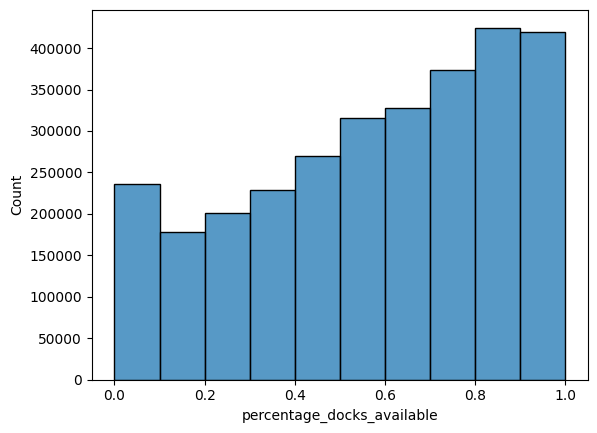

In [147]:
sns.histplot(dftotrain['percentage_docks_available'],bins=10)
plt.show()

In [108]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MSE": f"{mean_squared_error(y_true, y_pred):.3f}",
    }

#### Preparant el trainig amb estratificació ####


In [109]:
dftotrain["disponibilitat"] = pd.cut(dftotrain["percentage_docks_available"],
                               bins=[-0.01, 0.0, 0.2, 0.6, 0.8, 1.],
                               labels=['ple','força ple', 'mig buit', 'quasi buit', 'buit'])

In [110]:
dftotrain.loc[dftotrain["disponibilitat"]=='força ple']

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1,disponibilitat
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,0.244565,0.054348,força ple
3,1,2019,3,29,13,46.0,16.0,0.110507,0.525362,0.268116,0.253623,0.197464,força ple
4,1,2019,3,29,18,46.0,16.0,0.021739,0.019928,0.054348,0.013587,0.005435,força ple
5,1,2019,3,29,23,46.0,16.0,0.067029,0.047101,0.021739,0.010870,0.014493,força ple
7,1,2019,3,30,9,46.0,16.0,0.023551,0.000000,0.000000,0.000000,0.007246,força ple
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972323,519,2022,11,3,5,24.0,110.0,0.180556,0.184028,0.166667,0.166667,0.166667,força ple
2972434,519,2022,11,26,8,24.0,110.0,0.107639,0.277778,0.166667,0.125000,0.100694,força ple
2972438,519,2022,11,27,4,24.0,110.0,0.152778,0.468750,0.368056,0.291667,0.236111,força ple
2972538,519,2022,12,18,0,24.0,110.0,0.006944,0.420139,0.381944,0.288194,0.131944,força ple


In [111]:
dftotrain['disponibilitat'].unique()

['força ple', 'ple', 'mig buit', 'quasi buit', 'buit']
Categories (5, object): ['ple' < 'força ple' < 'mig buit' < 'quasi buit' < 'buit']

"""

#probem a estratificar amb varies variables:

#group=['station_id','month','hour','day'] no funciona:ValueError: The least populated class in y has only
1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

#group=['year','month','hour','day'] : MSE dona semblant,però un xic més alt

group=['month','hour','day'] : millor que sense res, pero inferior que els altres

X_train, X_test, y_train, y_test = train_test_split(dftotrain,y,test_size=.2,random_state=seed,shuffle=True,stratify=dftotrain[group])
X_train = X_train[features]
X_test = X_test[features]

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
#Make predictions
y_train_pred_lr = lin_reg.predict(X_train)
y_test_pred_lr = lin_reg.predict(X_test)
#Compute MSE for training and testing sets 
print('MSE (train | test):')
print(mean_squared_error(y_train_pred_lr, y_train), mean_squared_error(y_test_pred_lr, y_test))
""""

### Afegim features al training ###

In [112]:
dftotrain.head(3)

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1,disponibilitat
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,0.244565,0.054348,força ple
1,1,2019,3,29,3,46.0,16.0,0.000000,0.009058,0.003623,0.018116,0.000000,ple
2,1,2019,3,29,8,46.0,16.0,0.432971,0.009058,0.007246,0.036232,0.324275,mig buit


In [113]:
dftotrain.shape

(2972606, 13)

In [114]:
dftotrain.describe()

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1
count,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06,2.972606e+06
mean,2.505664e+02,2.020710e+03,6.914189e+00,1.576251e+01,1.151709e+01,2.703986e+01,3.388781e+01,5.772495e-01,5.771808e-01,5.771795e-01,5.771876e-01,5.771720e-01
std,1.447714e+02,1.070144e+00,3.351605e+00,8.807712e+00,6.921322e+00,6.407054e+00,3.114515e+01,2.858497e-01,2.859283e-01,2.858136e-01,2.858224e-01,2.858770e-01
min,1.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.200000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.260000e+02,2.020000e+03,4.000000e+00,8.000000e+00,6.000000e+00,2.400000e+01,8.000000e+00,3.589744e-01,3.589744e-01,3.589744e-01,3.589744e-01,3.583333e-01
50%,2.500000e+02,2.021000e+03,7.000000e+00,1.600000e+01,1.200000e+01,2.700000e+01,2.400000e+01,6.200000e-01,6.203704e-01,6.201923e-01,6.203704e-01,6.200000e-01
75%,3.700000e+02,2.022000e+03,1.000000e+01,2.300000e+01,1.800000e+01,3.000000e+01,4.900000e+01,8.240741e-01,8.240741e-01,8.240741e-01,8.240741e-01,8.240741e-01
max,5.190000e+02,2.023000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.400000e+01,1.660000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [194]:
class InfoAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,infoDF=pd.DataFrame()):
        self.infoDF = restore_stations_loc_info()
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X:pd.DataFrame, predict=False):
        if X.shape[1] == 8: #estem en el cas del submission file
            X = X.merge(self.infoDF[['station_id','capacity','altitude','n_transp_500m','min_dist_to_beach']],on=['station_id'],how='left') 
            X.insert(1, "year", 2023)
        else:
            X = X.merge(self.infoDF[['station_id','n_transp_500m','min_dist_to_beach']],on=['station_id'],how='left') 
        return X
    
info_attr_adder = InfoAttributesAdder()
train_attribs_added = info_attr_adder.fit_transform(dftotrain)    

In [116]:
train_attribs_added

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1,disponibilitat,n_transp_500m,min_dist_to_beach
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,0.244565,0.054348,força ple,3.0,2048.805533
1,1,2019,3,29,3,46.0,16.0,0.000000,0.009058,0.003623,0.018116,0.000000,ple,3.0,2048.805533
2,1,2019,3,29,8,46.0,16.0,0.432971,0.009058,0.007246,0.036232,0.324275,mig buit,3.0,2048.805533
3,1,2019,3,29,13,46.0,16.0,0.110507,0.525362,0.268116,0.253623,0.197464,força ple,3.0,2048.805533
4,1,2019,3,29,18,46.0,16.0,0.021739,0.019928,0.054348,0.013587,0.005435,força ple,3.0,2048.805533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972601,519,2022,12,31,3,24.0,110.0,0.791667,0.965278,0.881944,0.798611,0.819444,quasi buit,0.0,4777.728819
2972602,519,2022,12,31,8,24.0,110.0,0.833333,0.791667,0.791667,0.791667,0.802083,buit,0.0,4777.728819
2972603,519,2022,12,31,13,24.0,110.0,1.000000,0.871528,0.902778,0.965278,1.000000,buit,0.0,4777.728819
2972604,519,2022,12,31,18,24.0,110.0,0.906250,0.965278,0.944444,0.944444,0.875000,buit,0.0,4777.728819


In [117]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,festes=[]):
        self.festes = load_holidaysBCN()
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X:pd.DataFrame):
        X['weekend']= pd.to_datetime(X[['year','month','day']]).dt.weekday > 4
        X['peekhour'] = X['hour'].apply(lambda x: 1 if ((x in range(8,10)) | (x in range(17,19)) ) else 0)
        # i ara fem producte dfclean22['peekhour'] * dfclean22['workday'] pq només aplica si és laborable
        X['peekhour']= X.peekhour*(~X.weekend)
        # ara que ja hem actualitzat peekhour, podem convertir weekend -booleà- a integer
        X.weekend = X.weekend.replace({True: 1, False: 0})
        X['holiday']= pd.to_datetime(X[['day','month','year']]).isin(self.festes)
        X.holiday = X.holiday.replace({True: 1, False: 0})
        return X
        
comb_attr_adder = CombinedAttributesAdder()
train_attribs_added = comb_attr_adder.fit_transform(train_attribs_added)
train_attribs_added

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,ctx-2,ctx-1,disponibilitat,n_transp_500m,min_dist_to_beach,weekend,peekhour,holiday
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,0.244565,0.054348,força ple,3.0,2048.805533,0,0,0
1,1,2019,3,29,3,46.0,16.0,0.000000,0.009058,0.003623,0.018116,0.000000,ple,3.0,2048.805533,0,0,0
2,1,2019,3,29,8,46.0,16.0,0.432971,0.009058,0.007246,0.036232,0.324275,mig buit,3.0,2048.805533,0,1,0
3,1,2019,3,29,13,46.0,16.0,0.110507,0.525362,0.268116,0.253623,0.197464,força ple,3.0,2048.805533,0,0,0
4,1,2019,3,29,18,46.0,16.0,0.021739,0.019928,0.054348,0.013587,0.005435,força ple,3.0,2048.805533,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972601,519,2022,12,31,3,24.0,110.0,0.791667,0.965278,0.881944,0.798611,0.819444,quasi buit,0.0,4777.728819,1,0,0
2972602,519,2022,12,31,8,24.0,110.0,0.833333,0.791667,0.791667,0.791667,0.802083,buit,0.0,4777.728819,1,0,0
2972603,519,2022,12,31,13,24.0,110.0,1.000000,0.871528,0.902778,0.965278,1.000000,buit,0.0,4777.728819,1,0,0
2972604,519,2022,12,31,18,24.0,110.0,0.906250,0.965278,0.944444,0.944444,0.875000,buit,0.0,4777.728819,1,0,0


In [179]:
class WheatherAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,metDF=pd.DataFrame()):
        self.metDF = load_meteocat_data()
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X:pd.DataFrame):
        X = X.merge(self.metDF, on=['year','month','day','hour'],how='left')
        return X
    
wheather_adder = WheatherAttributesAdder()
train_attribs_added = wheather_adder.fit_transform(train_attribs_added)
train_attribs_added

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,...,disponibilitat,n_transp_500m,min_dist_to_beach,RS,PPT,P,HR,T,DV10,VV10
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,...,força ple,3.0,2048.805533,0.000000,0.0,1007.433333,65.666667,11.433333,283.666667,1.766667
1,1,2019,3,29,3,46.0,16.0,0.000000,0.009058,0.003623,...,ple,3.0,2048.805533,0.000000,0.0,1006.266667,47.333333,10.800000,307.666667,2.866667
2,1,2019,3,29,8,46.0,16.0,0.432971,0.009058,0.007246,...,mig buit,3.0,2048.805533,247.333333,0.0,1007.366667,53.666667,11.900000,118.000000,1.733333
3,1,2019,3,29,13,46.0,16.0,0.110507,0.525362,0.268116,...,força ple,3.0,2048.805533,836.333333,0.0,1007.300000,43.333333,16.266667,128.333333,2.733333
4,1,2019,3,29,18,46.0,16.0,0.021739,0.019928,0.054348,...,força ple,3.0,2048.805533,121.666667,0.0,1005.433333,56.666667,13.266667,104.666667,2.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972601,519,2022,12,31,3,24.0,110.0,0.791667,0.965278,0.881944,...,quasi buit,0.0,4777.728819,0.000000,0.0,1003.066667,56.666667,15.966667,290.666667,3.833333
2972602,519,2022,12,31,8,24.0,110.0,0.833333,0.791667,0.791667,...,buit,0.0,4777.728819,3.333333,0.0,1003.633333,55.333333,14.066667,268.000000,3.800000
2972603,519,2022,12,31,13,24.0,110.0,1.000000,0.871528,0.902778,...,buit,0.0,4777.728819,430.333333,0.0,1003.866667,37.000000,20.700000,259.000000,2.633333
2972604,519,2022,12,31,18,24.0,110.0,0.906250,0.965278,0.944444,...,buit,0.0,4777.728819,0.000000,0.0,1004.066667,72.000000,15.300000,244.666667,2.033333


In [119]:
train_attribs_added

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,...,weekend,peekhour,holiday,RS,PPT,P,HR,T,DV10,VV10
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,...,0,0,0,0.000000,0.0,1007.433333,65.666667,11.433333,283.666667,1.766667
1,1,2019,3,29,3,46.0,16.0,0.000000,0.009058,0.003623,...,0,0,0,0.000000,0.0,1006.266667,47.333333,10.800000,307.666667,2.866667
2,1,2019,3,29,8,46.0,16.0,0.432971,0.009058,0.007246,...,0,1,0,247.333333,0.0,1007.366667,53.666667,11.900000,118.000000,1.733333
3,1,2019,3,29,13,46.0,16.0,0.110507,0.525362,0.268116,...,0,0,0,836.333333,0.0,1007.300000,43.333333,16.266667,128.333333,2.733333
4,1,2019,3,29,18,46.0,16.0,0.021739,0.019928,0.054348,...,0,1,0,121.666667,0.0,1005.433333,56.666667,13.266667,104.666667,2.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972601,519,2022,12,31,3,24.0,110.0,0.791667,0.965278,0.881944,...,1,0,0,0.000000,0.0,1003.066667,56.666667,15.966667,290.666667,3.833333
2972602,519,2022,12,31,8,24.0,110.0,0.833333,0.791667,0.791667,...,1,0,0,3.333333,0.0,1003.633333,55.333333,14.066667,268.000000,3.800000
2972603,519,2022,12,31,13,24.0,110.0,1.000000,0.871528,0.902778,...,1,0,0,430.333333,0.0,1003.866667,37.000000,20.700000,259.000000,2.633333
2972604,519,2022,12,31,18,24.0,110.0,0.906250,0.965278,0.944444,...,1,0,0,0.000000,0.0,1004.066667,72.000000,15.300000,244.666667,2.033333


In [120]:
train_attribs_added.columns[train_attribs_added.isna().any()]

Index(['n_transp_500m', 'min_dist_to_beach'], dtype='object')

In [121]:
train_attribs_added.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2972606 entries, 0 to 2972605
Data columns (total 25 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   station_id                  int64   
 1   year                        int64   
 2   month                       int64   
 3   day                         int64   
 4   hour                        int64   
 5   capacity                    float64 
 6   altitude                    float64 
 7   percentage_docks_available  float64 
 8   ctx-4                       float64 
 9   ctx-3                       float64 
 10  ctx-2                       float64 
 11  ctx-1                       float64 
 12  disponibilitat              category
 13  n_transp_500m               float64 
 14  min_dist_to_beach           float64 
 15  weekend                     int64   
 16  peekhour                    int64   
 17  holiday                     int64   
 18  RS                          float64 
 19  

/var/folders/pp/2yt08yc96l37wdgrm0vrrvq40000gn/T/ipykernel_11399/2037682442.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_attribs_added.corr()


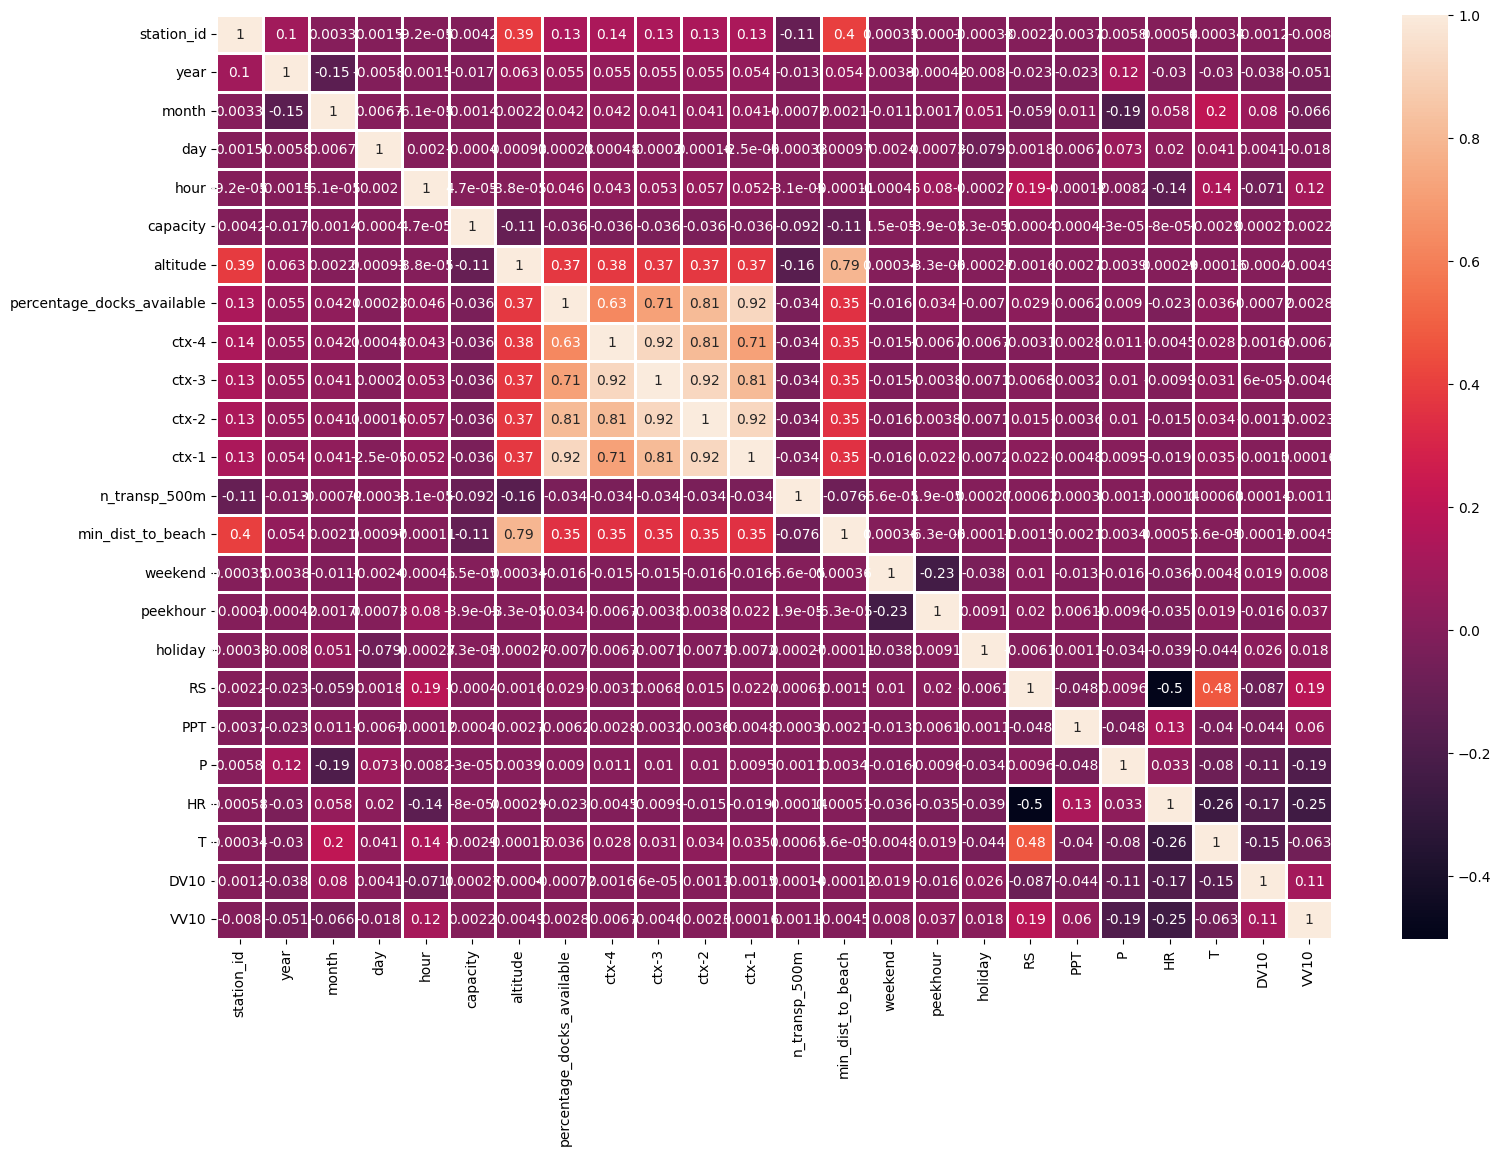

In [153]:
#Veiem la correlació entre todas las features numèriques
plt.figure(figsize=(18,12))
corr = train_attribs_added.corr()
sns.heatmap(data=corr, annot=True, fmt = '.2g', linewidth=1)
plt.show()

In [123]:
bicing = train_attribs_added.copy()
bicing

,station_id,year,month,day,hour,capacity,altitude,percentage_docks_available,ctx-4,ctx-3,...,weekend,peekhour,holiday,RS,PPT,P,HR,T,DV10,VV10
0,1,2019,3,28,22,46.0,16.0,0.021739,0.304348,0.280435,...,0,0,0,0.000000,0.0,1007.433333,65.666667,11.433333,283.666667,1.766667
1,1,2019,3,29,3,46.0,16.0,0.000000,0.009058,0.003623,...,0,0,0,0.000000,0.0,1006.266667,47.333333,10.800000,307.666667,2.866667
2,1,2019,3,29,8,46.0,16.0,0.432971,0.009058,0.007246,...,0,1,0,247.333333,0.0,1007.366667,53.666667,11.900000,118.000000,1.733333
3,1,2019,3,29,13,46.0,16.0,0.110507,0.525362,0.268116,...,0,0,0,836.333333,0.0,1007.300000,43.333333,16.266667,128.333333,2.733333
4,1,2019,3,29,18,46.0,16.0,0.021739,0.019928,0.054348,...,0,1,0,121.666667,0.0,1005.433333,56.666667,13.266667,104.666667,2.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972601,519,2022,12,31,3,24.0,110.0,0.791667,0.965278,0.881944,...,1,0,0,0.000000,0.0,1003.066667,56.666667,15.966667,290.666667,3.833333
2972602,519,2022,12,31,8,24.0,110.0,0.833333,0.791667,0.791667,...,1,0,0,3.333333,0.0,1003.633333,55.333333,14.066667,268.000000,3.800000
2972603,519,2022,12,31,13,24.0,110.0,1.000000,0.871528,0.902778,...,1,0,0,430.333333,0.0,1003.866667,37.000000,20.700000,259.000000,2.633333
2972604,519,2022,12,31,18,24.0,110.0,0.906250,0.965278,0.944444,...,1,0,0,0.000000,0.0,1004.066667,72.000000,15.300000,244.666667,2.033333


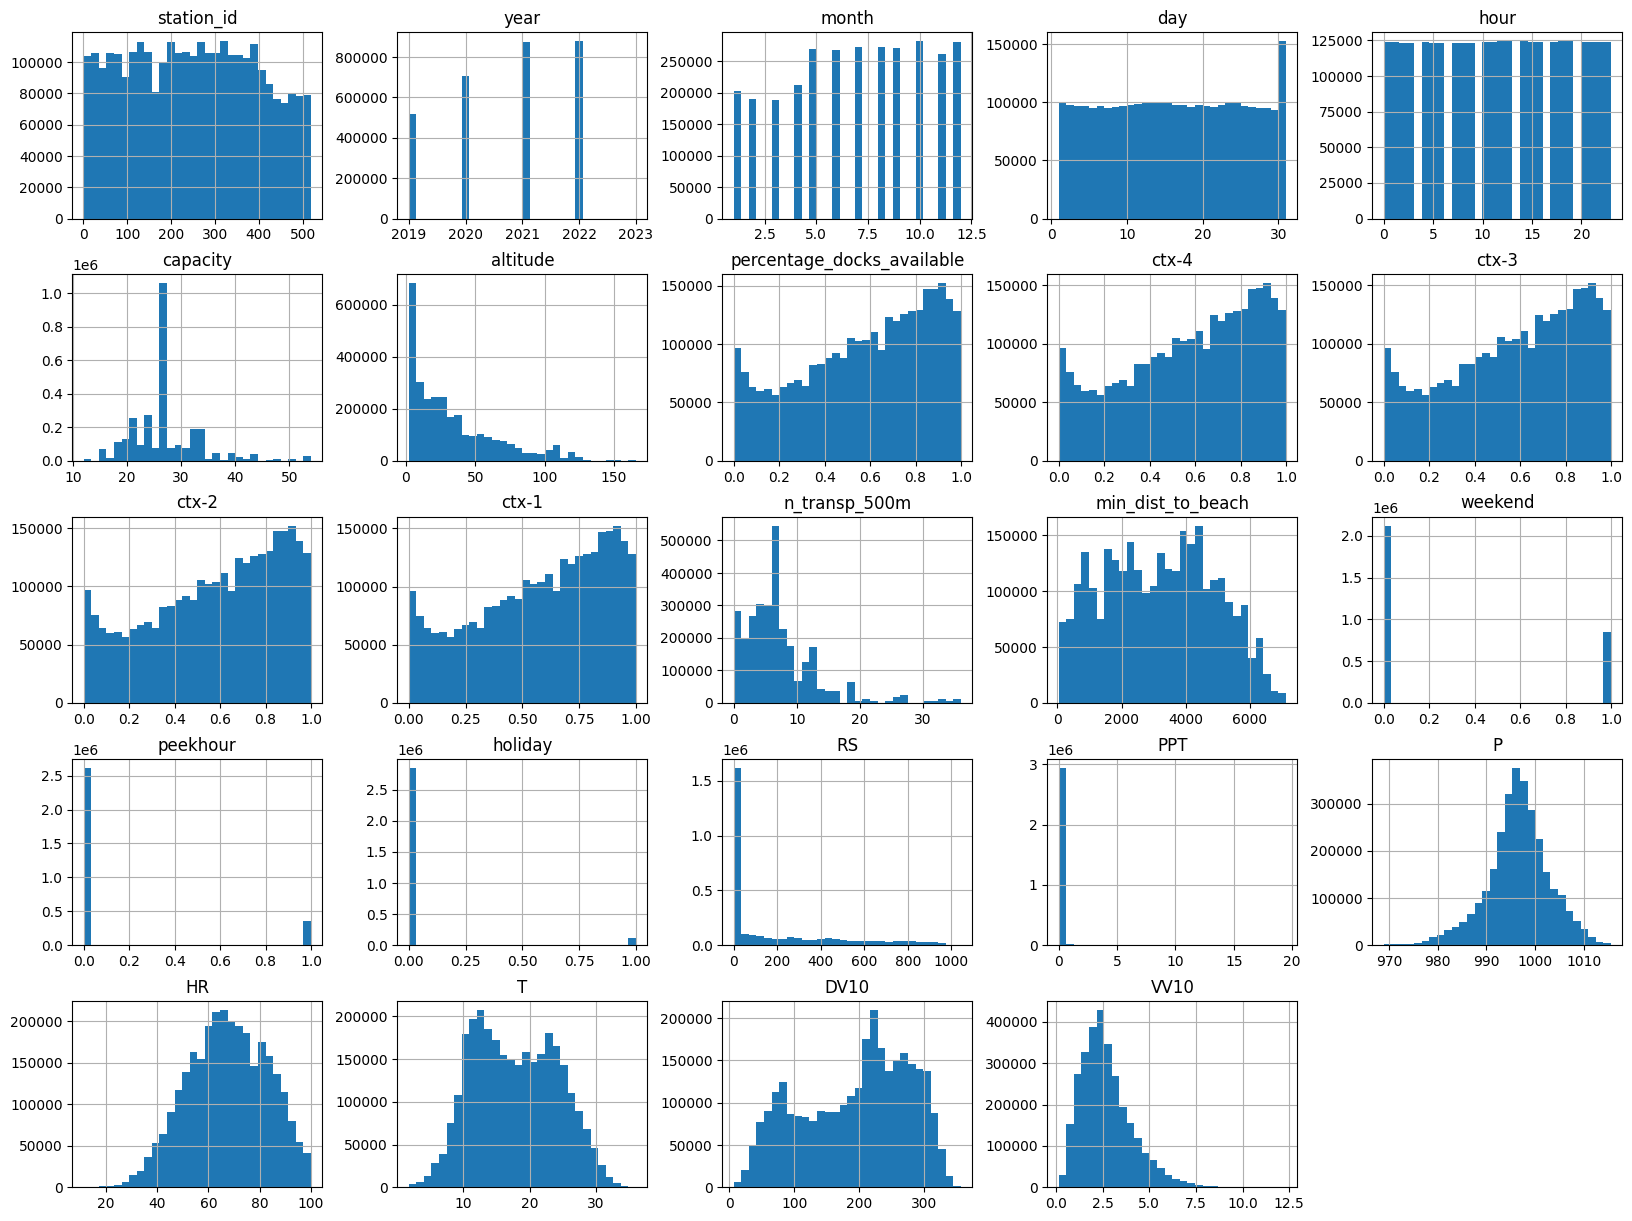

In [124]:
bicing.hist(bins=30, figsize=(20,15))
plt.show()

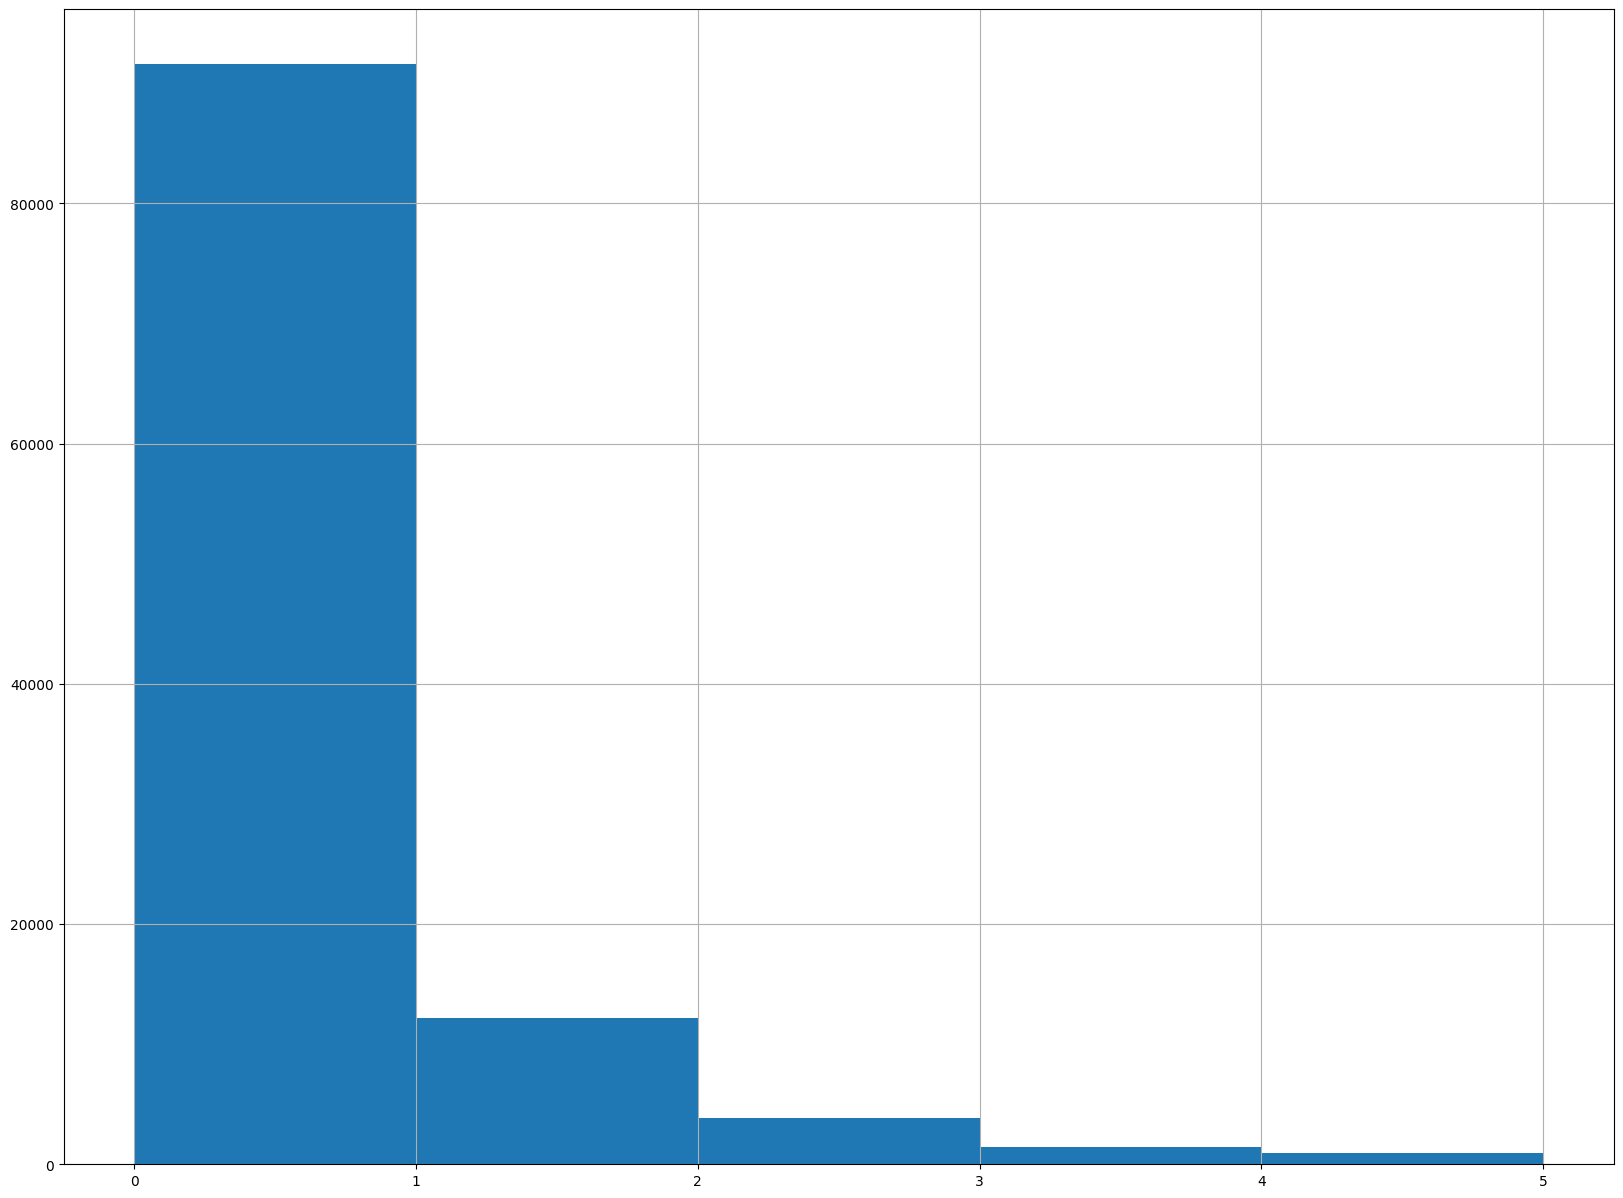

In [82]:
#mirem les dades de precipitació en detall
bicing.loc[bicing['PPT']>0,'PPT'].hist(bins=[0,1,2,3,4,5],figsize=(20,15))
plt.show()

**Fem split amb estratificació**

In [125]:
labels=bicing['percentage_docks_available'].copy()

In [126]:
labels.isna().any()

False

In [127]:
X_train, X_test, y_train, y_test = train_test_split(bicing,labels,test_size=.2,random_state=seed,shuffle=True,stratify=bicing['disponibilitat'])

In [128]:
#eliminem la columna target i la categòrica que hem fet servir per estratificar
for set_ in (X_train, X_test):
    set_.drop(columns=['percentage_docks_available','disponibilitat'],inplace=True)

In [129]:
print('Training Shape: X {} , y: {}'.format(X_train.shape,y_train.shape))
print('Testing Shape: X {} , y: {}'.format(X_test.shape,y_test.shape))

Training Shape: X (2378084, 23) , y: (2378084,)
Testing Shape: X (594522, 23) , y: (594522,)


In [130]:
X_train.columns[X_train.isna().any()]

Index(['n_transp_500m', 'min_dist_to_beach'], dtype='object')

In [135]:
X_train

,station_id,year,month,day,hour,capacity,altitude,ctx-4,ctx-3,ctx-2,...,weekend,peekhour,holiday,RS,PPT,P,HR,T,DV10,VV10
1307303,221,2022,11,7,17,24.0,68.0,0.881410,0.906250,0.850694,...,0,1,0,23.666667,0.000000,997.766667,75.666667,17.566667,231.000000,2.300000
126916,22,2021,8,22,15,19.0,28.0,0.732456,0.832536,0.688596,...,1,0,0,689.333333,0.000000,1000.266667,65.333333,28.233333,159.666667,3.000000
413482,71,2020,6,4,6,21.0,16.0,0.408730,0.476190,0.476190,...,0,0,0,0.000000,0.066667,981.800000,86.666667,17.533333,299.000000,1.566667
48997,8,2022,5,16,0,27.0,6.0,0.429012,0.425926,0.413580,...,0,0,0,0.000000,0.000000,998.066667,50.666667,19.500000,273.666667,1.133333
2819508,485,2022,9,1,18,27.0,121.0,0.429012,0.481481,0.472222,...,0,1,0,353.333333,0.000000,993.066667,60.333333,28.066667,173.666667,2.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919613,154,2022,10,4,0,32.0,2.0,0.510417,0.468750,0.187500,...,0,0,0,0.000000,0.000000,999.800000,86.000000,19.000000,260.000000,0.766667
2643510,445,2022,10,22,18,24.0,21.0,0.163194,0.284722,0.312500,...,1,0,0,51.333333,0.000000,995.300000,49.666667,22.766667,208.333333,2.766667
1179138,201,2021,1,31,15,24.0,55.0,0.784722,0.850694,0.857639,...,1,0,0,406.666667,0.000000,982.366667,46.333333,16.166667,281.666667,5.266667
155335,27,2019,10,2,21,21.0,38.0,0.869048,0.892857,0.944444,...,0,0,0,0.000000,0.000000,994.200000,68.000000,20.133333,109.000000,2.033333


**Transformacions**

In [136]:
# variables numèriques

num1_attribs=['altitude','RS','PPT','VV10']
num1_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('log',FunctionTransformer(np.log1p)),
        ('std_scaler', StandardScaler()),
    ])

num2_attribs = ['month','hour','HR','T']  
num2_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

num3_attribs=['ctx-4','ctx-3','ctx-2','ctx-1','weekend','peekhour'] #passthrough

In [132]:
#variables categòriques

def transform_Num_to_Cat(data):
    data = data.astype('object') 
    return data

cat1_attribs = ['station_id']
cat1_pipeline = Pipeline([
        ('transform_to_Cat',FunctionTransformer(func = transform_Num_to_Cat,validate=False)),
        ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

cat2_attribs=['post_code'] #post_code ja és categòrica
cat2_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="constant",fill_value='Unknown')),  
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [137]:
full_pipeline = ColumnTransformer([
        ("num1", num1_pipeline, num1_attribs),
        ("num2", num2_pipeline, num2_attribs),
#        ("cat1", cat1_pipeline, cat1_attribs),
        ("num3", 'passthrough', num3_attribs)
        ])

Fit and Transform train

In [138]:
train_prepared = full_pipeline.fit_transform(X_train[num1_attribs+num2_attribs+num3_attribs])

In [139]:
train_prepared

array([[ 1.12779005,  0.15812218, -0.12501115, ...,  0.79513889,
         0.        ,  1.        ],
       [ 0.2531122 ,  1.33498079, -0.12501115, ...,  0.72874494,
         1.        ,  0.        ],
       [-0.28581762, -0.97413466,  0.45802176, ...,  0.47619048,
         0.        ,  0.        ],
       ...,
       [ 0.91714057,  1.14892668, -0.12501115, ...,  0.74305556,
         1.        ,  0.        ],
       [ 0.55206692, -0.97413466, -0.12501115, ...,  0.97802198,
         0.        ,  0.        ],
       [ 0.84236   ,  0.76201907, -0.12501115, ...,  0.43010753,
         0.        ,  0.        ]])

In [140]:
train_prepared.shape

(2378084, 14)

Transform test

In [141]:
test_prepared=full_pipeline.transform(X_test[num1_attribs+num2_attribs+cat1_attribs+num3_attribs])

In [142]:
test_prepared.shape

(594522, 14)

In [145]:
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, y_train)

# Make predictions
y_train_pred_lr = lin_reg.predict(train_prepared)
y_test_pred_lr = lin_reg.predict(test_prepared)

# Compute MSE for training and testing sets 
print('MSE (train | test):')
print(mean_squared_error(y_train_pred_lr, y_train), mean_squared_error(y_test_pred_lr, y_test))

print('R2 (train | test):')
print(r2_score(y_train_pred_lr, y_train), r2_score(y_test_pred_lr, y_test))

MSE (train | test):
0.01195826455205245 0.011758809500616585
R2 (train | test):
0.8285431989302312 0.8314711772236297


hora i mes i dist_platges

MSE (train | test):
0.011883371285297036 0.011686851128218663
R2 (train | test):
0.8297995323180921 0.8326980913954616

In [144]:
forest_reg = RandomForestRegressor(random_state=seed) #afegir n_estimators=20 que per defecte és 100
forest_reg.fit(train_prepared, y_train)
 # Make predictions
y_train_fr = forest_reg.predict(train_prepared)

#test_prepared=full_pipeline.fit_transform(X_test)

y_test_fr = forest_reg.predict(test_prepared)

# Compute MSE for training and testing sets 
print('MSE (train | test):')
print(mean_squared_error(y_train_fr, y_train), mean_squared_error(y_test_fr, y_test))
print('R2 (train | test):')
print(r2_score(y_train_fr, y_train), r2_score(y_test_fr, y_test))

MSE (train | test):
0.0015281045979033243 0.010738671476996902
R2 (train | test):
0.9795423167314217 0.8453139091697832


In [ ]:
grad_reg = GradientBoostingRegressor(n_estimators=100,random_state=seed,max_features=1.0, criterion='squared_error')
grad_reg.fit(train_prepared, y_train)  

# Make predictions
y_train_gr = grad_reg.predict(train_prepared)

y_test_gr = grad_reg.predict(test_prepared)

# Compute MSE for training and testing sets 
print('MSE (train | test):')
print(mean_squared_error(y_train_gr, y_train), mean_squared_error(y_test_gr, y_test))
print('R2 (train | test):')
print(r2_score(y_train_gr, y_train), r2_score(y_test_gr, y_test))

In [ ]:
n_neighbors = 3
knn_reg = neighbors.KNeighborsRegressor(n_neighbors)
knn_reg.fit(train_prepared, y_train)

# Make predictions
y_train_kn = knn_reg.predict(train_prepared)

y_test_kn = knn_reg.predict(test_prepared)

# Compute MSE for training and testing sets 
print('MSE (train | test):')
print(mean_squared_error(y_train_kn, y_train), mean_squared_error(y_test_kn, y_test))
print('R2 (train | test):')
print(r2_score(y_train_kn, y_train), r2_score(y_test_kn, y_test))

In [ ]:
## lets compare all of them 
allscores=[]
def display_scores(scores, model_name = None):
    if(model_name):
        print("----",model_name,"----")
    allscores.append([model_name,scores.mean(),scores.std()])
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

lin_reg2 = LinearRegression()
knn_reg2 = neighbors.KNeighborsRegressor(5)
forest_reg2 = RandomForestRegressor(random_state=seed)
grad_reg2 = GradientBoostingRegressor(n_estimators=100,random_state=seed,max_features=1.0, criterion='squared_error')
    
models = [(lin_reg2,"lin_reg",-1,-1),
          (knn_reg2,"KNN-Regressor",-1,-1),
          (forest_reg2,'Random Forest',-1,-1),
          (grad_reg2,'Gradient Boosting',-1,-1)]
modelScores=pd.DataFrame(models,columns=['Model','Name','Mean','Std'])

In [ ]:
for model in models:
    scores = cross_val_score(model[0], train_prepared, y_train, scoring="neg_mean_squared_error", cv=10)
    display_scores(-scores,model[1])
    
allscores= pd.DataFrame(allscores,columns=['Name','Mean','Std'])

**Seach of best hyperparameters**

In [ ]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 20, 50, 100], 'max_features': [5, 8, 18], 'max_depth':[3,5,7,10]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [10, 30, 50], 'max_features': [5, 8, 18]},
  ]

forest_reg2 = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg2, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_prepared, y_train)


### Notes prediccions ###

#### 16/05/2023: I think something went wrong with the files ####

- RandomForestRegressor(n_estimators=20, random_state=42)
- MSE (train | test):
- 0.0013752198833196705 0.001560372795458149

#### 18/05/2023: 2022 data only #### 
- RandomForestRegressor(n_estimators=20, random_state=42)
- MSE (train | test):
- 0.0020430191261473067 0.012574955517808432

#### 21/05/2023: ####
- RandomForestRegressor(n_estimators=20, random_state=42)
- MSE (train | test):
- 0.0022623862347308284 0.012974909618175656

- LinearRegression()
- MSE (train | test):
- 0.012224824865615715 0.012273542087721093

#### 22/05/2023: ####
- LinearRegression() + stratificat categoria 'disponibilitat'
- MSE (train | test):
- 0.012272287882953791 0.01208374240252064

#### 25/05/2023: global.df
- LinearRegression()
- MSE (train | test):
- 0.014008306896792399 0.014022284539283952

#### 26/05/2023: Nou fitxer training ####
- LinearRegression() 
- MSE (train | test):
- 0.012078006010124561 0.012059598577670987

#### 30/05/2023:  
#### stratificacio: mes,dia i hora
- LinearRegression() 
- MSE (train | test):
- 0.01208940624657823 0.012013998523032027

#### stratificacio: categoria disponibilitat
- LinearRegression() 
- MSE (train | test):
- 0.012114677756332919 0.011912930260635139

#### 03/06/2023:  stratificació disp + weather feat+weekend+peekhour (sense station_id ni capacity)
**LinearRegression**
- MSE (train | test):
- 0.011958292744636502 0.011760218193388865  --> submission set score: 0.12427

**Random Forest**
- MSE (train | test):
- 0.0015202273211973466 0.010681439728055818  --> submission set score: 0.36 :(
- R2 (train | test):
- 0.9796371574154732 0.8458634173568492

#### 08/06/2023:  stratificació disp + weather feat(nova versió) +weekend+peekhour (sense station_id ni capacity)
**LinearRegression**
- MSE (train | test):
- 0.01195826455205245 0.011758809500616585  

**Random Forest**
- MSE (train | test):
- 0.0015281045979033243 0.010738671476996902  --> submission set score: 0.12107 
- R2 (train | test):
- 0.9795423167314217 0.8453139091697832

### Predir el submission set ###

In [195]:
add_features = Pipeline([
        ('info',InfoAttributesAdder()),
        ('comb', CombinedAttributesAdder()),
        ('weather', WheatherAttributesAdder())
    ])

In [196]:
submission_set = pd.read_csv(f'submission/metadata_sample_submission.csv',index_col=0)
submission_set

,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1
index,,,,,,,,
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160
...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261
54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160
54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778


In [197]:
submission_set = add_features.fit_transform(submission_set)
submission_set

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,capacity,...,weekend,peekhour,holiday,RS,PPT,P,HR,T,DV10,VV10
0,394,2023,3,7,8,0.753086,0.780864,0.799383,0.824074,27,...,0,1,0,134.666667,0.0,987.333333,65.666667,9.766667,199.333333,1.700000
1,337,2023,3,23,12,0.463768,0.536232,0.532609,0.601449,23,...,0,0,0,788.333333,0.0,995.466667,66.000000,17.666667,217.000000,3.466667
2,368,2023,3,31,1,0.787037,0.709877,0.611111,0.601852,27,...,0,0,0,0.000000,0.0,997.866667,81.666667,13.633333,266.333333,2.500000
3,327,2023,3,23,15,0.753472,0.809028,0.819444,0.736111,24,...,0,0,0,645.000000,0.0,994.200000,68.000000,17.300000,217.666667,4.233333
4,328,2023,3,4,20,0.861111,0.802469,0.814815,0.827160,27,...,1,0,0,0.000000,0.0,998.333333,63.333333,9.633333,297.333333,2.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,269,2023,3,14,3,0.478261,0.478261,0.478261,0.478261,23,...,0,0,0,0.000000,0.0,990.800000,44.666667,14.633333,213.333333,1.500000
54995,280,2023,3,1,5,0.098765,0.074074,0.074074,0.077160,27,...,0,0,0,0.000000,0.0,995.400000,49.333333,3.166667,299.000000,3.600000
54996,180,2023,3,20,16,0.782680,0.821895,0.812092,0.777778,51,...,0,0,0,386.666667,0.0,999.166667,65.000000,15.833333,129.000000,2.366667
54997,277,2023,3,14,11,0.774691,0.953704,0.972222,0.472222,27,...,0,0,0,698.666667,0.0,993.900000,35.333333,17.466667,306.333333,4.366667


In [199]:
X_pred = full_pipeline.transform(submission_set)
X_pred

array([[ 0.14292182,  0.76028755, -0.12501115, ...,  0.82407407,
         0.        ,  1.        ],
       [ 1.66923815,  1.38231839, -0.12501115, ...,  0.60144928,
         0.        ,  0.        ],
       [-0.02564845, -0.97413466, -0.12501115, ...,  0.60185185,
         0.        ,  0.        ],
       ...,
       [-0.41211674,  1.13115789, -0.12501115, ...,  0.77777778,
         0.        ,  0.        ],
       [ 1.00343895,  1.33972446, -0.12501115, ...,  0.47222222,
         0.        ,  0.        ],
       [-1.33672372,  1.27427841, -0.12501115, ...,  0.78819444,
         0.        ,  0.        ]])

In [200]:
y_pred = forest_reg.predict(X_pred)
df_output = pd.DataFrame(y_pred)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']
avui = datetime.today()
name = 'submission/submission-{}-{}-{}-{}.csv'.format(avui.year,avui.month,avui.day,avui.hour)
df_output.to_csv(name,index=False)

In [ ]:
def predict_bicing2023(subset, model):
    
    X_pred = add_features.fit_transform(subset)
    X_pred = full_pipeline.transform(X_pred)

    y_pred = model.predict(X_pred)
    #preparem el fitxer per pujar a kaggle
    df_output = pd.DataFrame(y_pred)
    df_output = df_output.reset_index()
    df_output.columns = ['index','percentage_docks_available']
    avui = datetime.today()
    name = 'submission/submission-{}-{}-{}-{}.csv'.format(avui.year,avui.month,avui.day,avui.hour)
    df_output.to_csv(name,index=False)

### Entrenem el fitxer global_df ###

In [ ]:
glob = pd.read_csv(f'data_bicing/global_df.csv')
glob

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

seed=42

features=['ctx-4','ctx-3','ctx-2','ctx-1']

X = glob[features].fillna(0)

y = glob['percentage_docks_available'].fillna(0).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=seed,shuffle=True)

lin_reg = LinearRegression()
lin_reg.fit(X_train[features], y_train)

# Make predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Compute MSE for training and testing sets 
print('MSE (train | test):')
print(mean_squared_error(y_train_pred, y_train), mean_squared_error(y_test_pred, y_test))

-LinearRegression() amb **global.df** i features=**['ctx-4','ctx-3','ctx-2','ctx-1']**

-MSE (train | test):
-0.014008306896792399 0.014022284539283952